In [12]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qci_client import QciClient
from scipy.sparse import dok_matrix
from qseg.graph_utils import image_to_grid_graph, draw
from qseg.utils import decode_binary_string
from scipy.ndimage import label
import cv2

# Configurar el cliente de QCI
#token = "893a0474617e13d40d149c0cd35a10df" #mia
#token = "a4b95f0b6fb4842ab4510341c19d6820"#profe
token = "fd1e31875feb8c237e908064848e7df9"
#mario

api_url = "https://api.qci-prod.com"
qclient = QciClient(api_token=token, url=api_url)

# Imagen de prueba (3x3)
#image = np.array([
    #[0.82, 0.78, 0.99],
   # [0.83, 0.40, 0.95],
   # [0.1, 0.05, 0.16]
#])

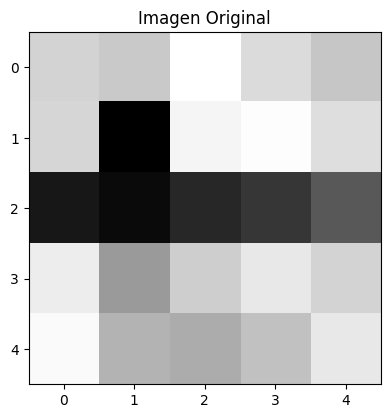

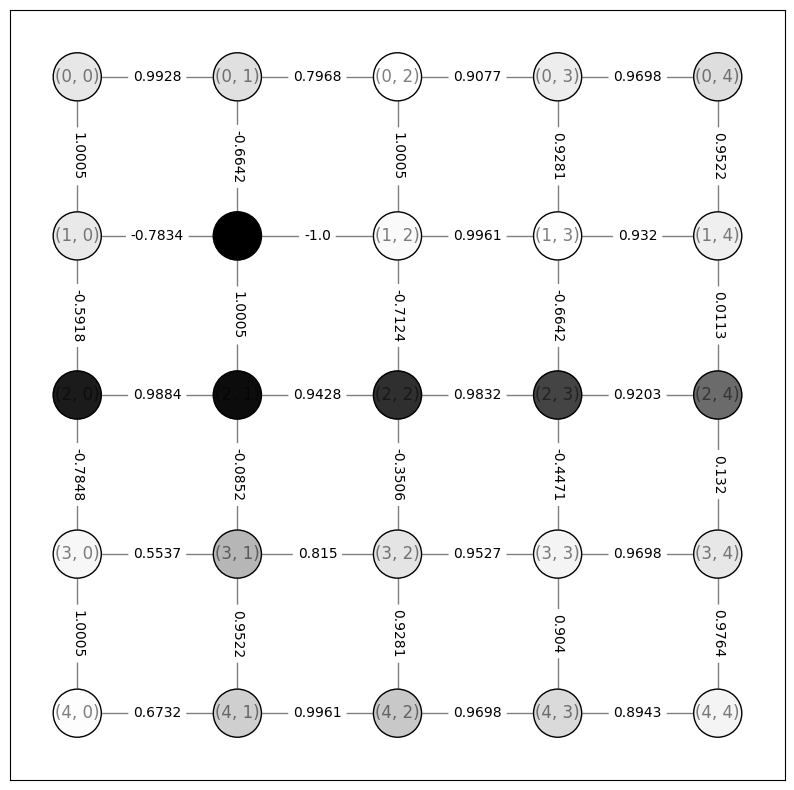

In [13]:
# Para este ejemplo, creamos una imagen sintética similar a la que mostraste
image = np.array([
    [0.82, 0.78, 0.99, 0.85, 0.77],
    [0.83, 0.01, 0.95, 0.98, 0.86],
    [0.1, 0.05, 0.16, 0.22, 0.35],
    [0.92, 0.60, 0.80, 0.90, 0.82],
    [0.97, 0.70, 0.67, 0.75, 0.90]
])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")

# Convertir imagen en un grafo
normalized_nx_elist = image_to_grid_graph(image)
G = nx.grid_2d_graph(image.shape[0], image.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
draw(G, image)

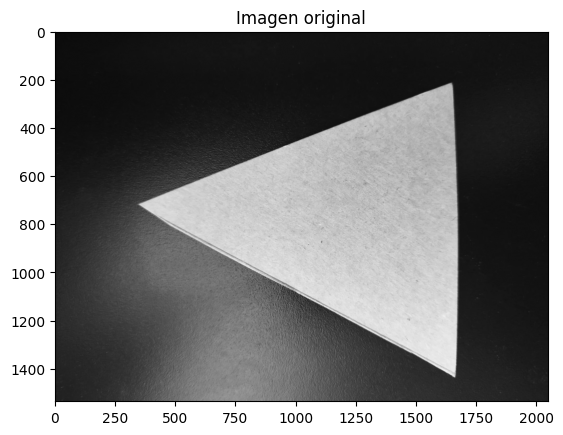

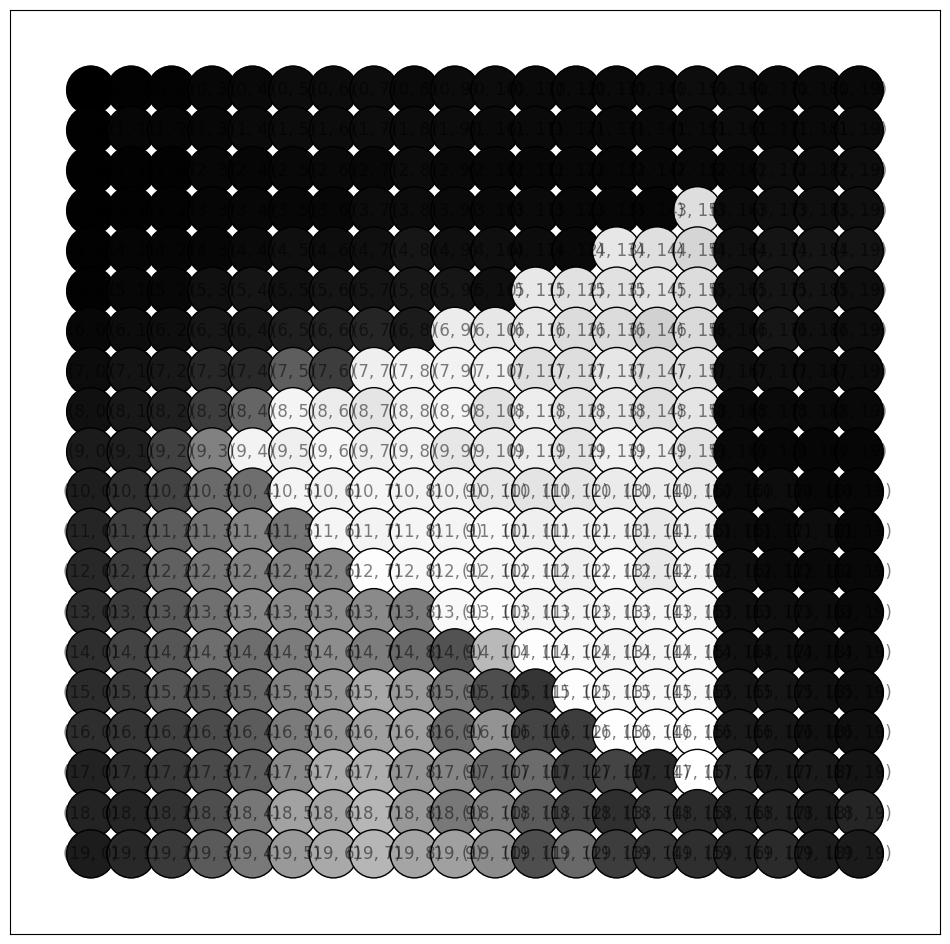

In [14]:
# Cargar imagen y convertir a escala de grises
image_path = r"C:\Users\carlo\TFG\Q-Seg\Negro.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#image = cv2.resize(image, (100, 100))  # Redimensionar para reducir el tamaño computacional
image = image / 255.0  # Normalizar valores entre 0 y 1
height, width = image.shape

plt.imshow(image, cmap='gray')
plt.title("Imagen original")
plt.show()

# Redimensionar la imagen antes de crear el grafo
target_size = (20, 20)  # Ajusta según necesites
image_resized = cv2.resize(image, target_size)

# Crear grafo con la imagen redimensionada
normalized_nx_elist = image_to_grid_graph(image_resized)  
G = nx.grid_2d_graph(image_resized.shape[0], image_resized.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
height, width = image_resized.shape
draw(G, image_resized)

In [19]:
# QUBO construction with tunable parameters
alpha, beta = 10.0, 0.5  # Alpha cuenta la intensidad de cada pixel y beta
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Término de datos
for node in G.nodes:
    i = node_mapping[node]
    intensity = image[node[0], node[1]]
    qubo_matrix[i, i] += alpha * (1 - 2 * intensity)  # Si la intensidad es baja 0 si alta 1

# Término de suavizado
for (u, v, weight) in G.edges(data=True):
    i, j = node_mapping[u], node_mapping[v]        #si dos terminos estan unidos se suma energia (mejor)
    w = weight["weight"]
    qubo_matrix[i, i] += beta * w
    qubo_matrix[j, j] += beta * w
    qubo_matrix[i, j] -= 2 * beta * w
    qubo_matrix[j, i] -= 2 * beta * w

qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
response_json = qclient.upload_file(file=qubo_data)


2025-05-10 13:50:04 - Dirac allocation balance = 585 s
2025-05-10 13:50:04 - Job submitted: job_id='681f3d6a7022694b835bffd0'
2025-05-10 13:50:04 - QUEUED
2025-05-10 13:50:07 - RUNNING
2025-05-10 13:50:20 - COMPLETED
2025-05-10 13:50:23 - Dirac allocation balance = 580 s


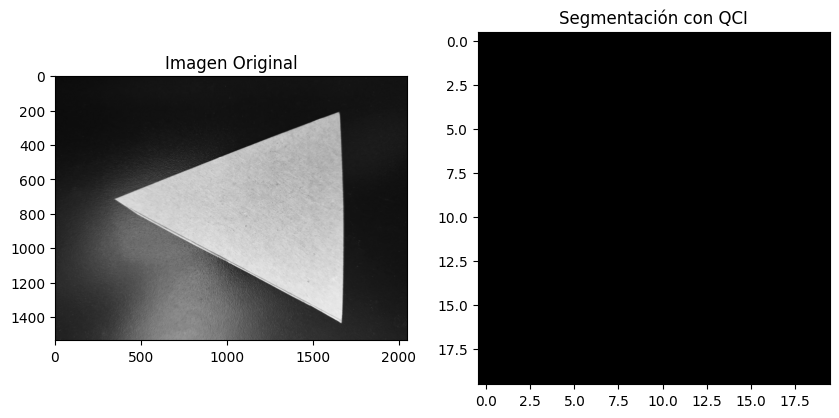

In [20]:
# Enviar trabajo a QCI y manejar errores

# Submit job with more samples
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}  # Aumentamos las muestras
)
job_response = qclient.process_job(job_body=job_body)

# Select best solution
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]      #cuanto menor energia mejor es la solucion en QUBO
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]

# Decode and post-process
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])
#labeled, _ = label(segmentation_mask) #componentes conectadas
#sizes = np.bincount(labeled.ravel())
#mask = sizes[labeled] > 2  # quitamos los pixeles sueltos que no pertenecen a una figura grande
#segmentation_mask = mask * segmentation_mask

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con QCI")
plt.show()

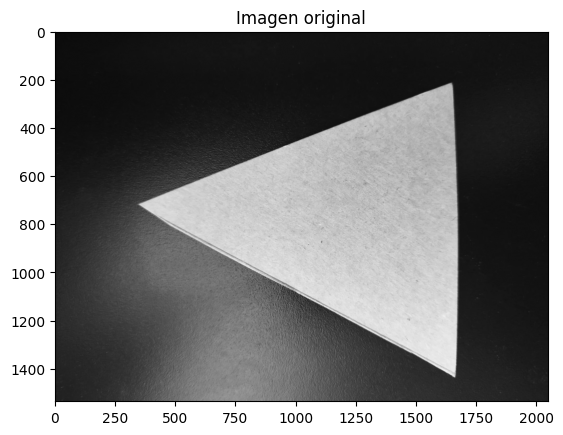

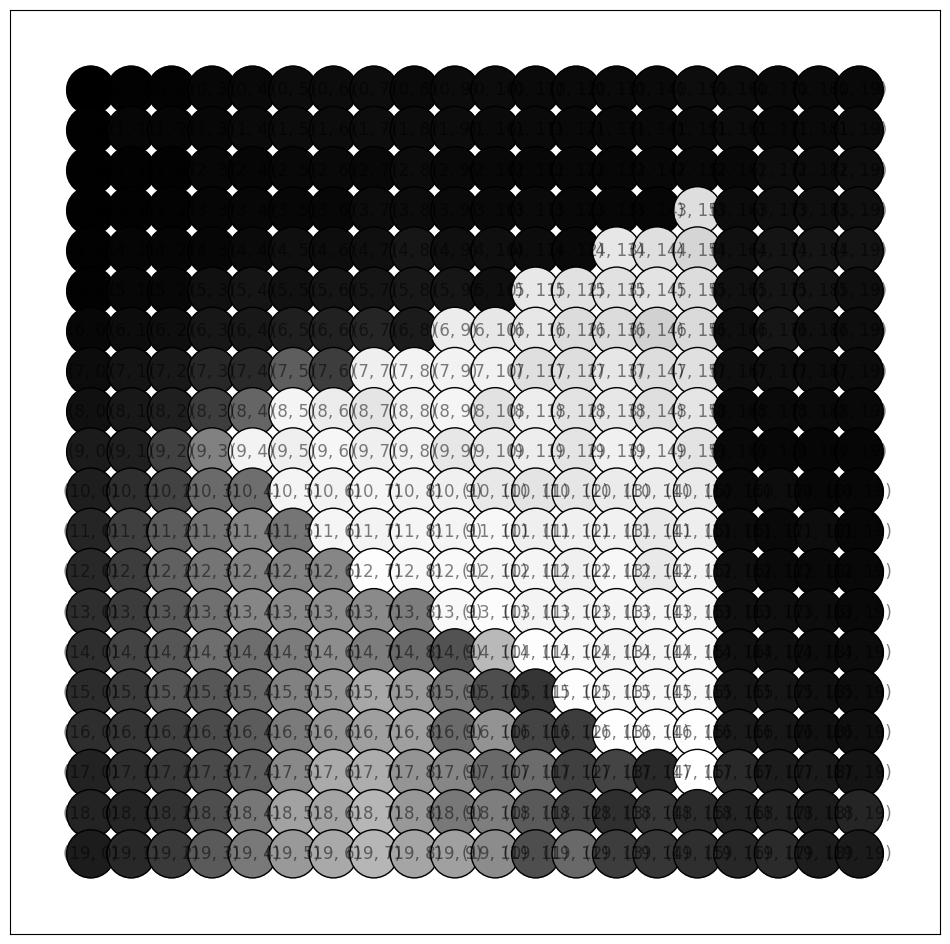

In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from qci_client import QciClient
from scipy.sparse import dok_matrix
from qseg.graph_utils import image_to_grid_graph, draw
from qseg.utils import decode_binary_string
from scipy.ndimage import label
import cv2

# Configurar el cliente de QCI
#token = "893a0474617e13d40d149c0cd35a10df"
token = "fd1e31875feb8c237e908064848e7df9"
#mario

api_url = "https://api.qci-prod.com"
qclient = QciClient(api_token=token, url=api_url)

# Cargar imagen y convertir a escala de grises
image_path = r"C:\Users\carlo\TFG\Q-Seg\Negro.jpeg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")
image = image / 255.0  # Normalizar valores entre 0 y 1
height, width = image.shape

plt.imshow(image, cmap='gray')
plt.title("Imagen original")
plt.show()

# Redimensionar la imagen antes de crear el grafo
target_size = (20, 20)
image_resized = cv2.resize(image, target_size)

# Crear grafo con la imagen redimensionada
normalized_nx_elist = image_to_grid_graph(image_resized)
G = nx.grid_2d_graph(image_resized.shape[0], image_resized.shape[1])
G.add_weighted_edges_from(normalized_nx_elist)
height, width = image_resized.shape
draw(G, image_resized)

# Construcción del QUBO para Max-Cut
node_mapping = {node: i for i, node in enumerate(G.nodes)}
num_nodes = len(G.nodes)
qubo_matrix = dok_matrix((num_nodes, num_nodes), dtype=np.float32)

# Término unario: guía la segmentación según la intensidad (Max-Cut)
alpha = 5.0  # Mayor peso para la intensidad
for node in G.nodes:
    i = node_mapping[node]
    intensity = image_resized[node[0], node[1]]
    # Alta intensidad -> 1 (foreground), baja intensidad -> 0 (background)
    qubo_matrix[i, i] += alpha * (2 * intensity - 1)

# Término de Max-Cut: maximiza el peso de las aristas entre conjuntos diferentes
beta = 1.0  # Peso para el corte
for (u, v, weight) in G.edges(data=True):
    i, j = node_mapping[u], node_mapping[v]
    w = weight["weight"]
    # Términos de Max-Cut: -w (x_i + x_j - 2 x_i x_j)
    qubo_matrix[i, i] += -beta * w  # Término x_i
    qubo_matrix[j, j] += -beta * w  # Término x_j
    qubo_matrix[i, j] += 2 * beta * w  # Término -2 x_i x_j
    qubo_matrix[j, i] += 2 * beta * w  # Simétrico

# Convertir la matriz QUBO a formato numpy y enviarla a QCI
qubo_numpy = qubo_matrix.toarray()
qubo_data = {"file_name": "qubo_data.json", "file_config": {"qubo": {"data": qubo_numpy}}}
try:
    response_json = qclient.upload_file(file=qubo_data)
except Exception as e:
    print(f"Error al subir el archivo a QCI: {e}")
    exit(1)


2025-05-10 13:42:56 - Dirac allocation balance = 600 s
2025-05-10 13:42:56 - Job submitted: job_id='681f3bbf7022694b835bffcd'
2025-05-10 13:42:57 - QUEUED
2025-05-10 13:42:59 - RUNNING
2025-05-10 13:43:13 - COMPLETED
2025-05-10 13:43:16 - Dirac allocation balance = 595 s
Respuesta de QCI: {'job_info': {'job_id': '681f3bbf7022694b835bffcd', 'job_submission': {'problem_config': {'quadratic_unconstrained_binary_optimization': {'qubo_file_id': '681f3bb75e0855263229207d'}}, 'device_config': {'dirac-1': {'num_samples': 1}}}, 'job_status': {'submitted_at_rfc3339nano': '2025-05-10T11:42:55.304Z', 'queued_at_rfc3339nano': '2025-05-10T11:42:55.305Z', 'running_at_rfc3339nano': '2025-05-10T11:42:55.582Z', 'completed_at_rfc3339nano': '2025-05-10T11:43:10.638Z'}, 'job_result': {'file_id': '681f3bce5e0855263229207f', 'device_usage_s': 5}}, 'status': 'COMPLETED', 'results': {'counts': [1], 'energies': [-1034.367749016732], 'solutions': [[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0

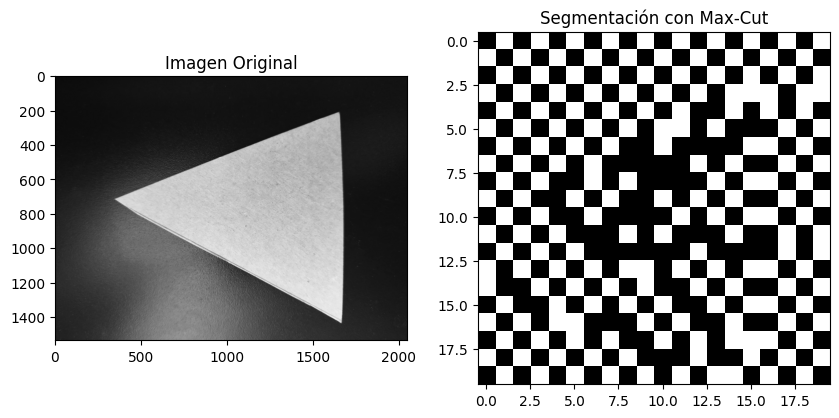

In [11]:

# Enviar trabajo a QCI
job_body = qclient.build_job_body(
    job_type="sample-qubo",
    qubo_file_id=response_json["file_id"],
    job_params={"device_type": "dirac-1", "num_samples": 1}
)
try:
    job_response = qclient.process_job(job_body=job_body)
except Exception as e:
    print(f"Error al procesar el trabajo en QCI: {e}")
    exit(1)

# Seleccionar la mejor solución
solutions = job_response["results"]["solutions"]
energies = job_response["results"]["energies"]
best_solution = solutions[np.argmin(energies)]
solution_binary_string = [int(best_solution[node_mapping[node]]) for node in G.nodes]

# Decodificación
segmentation_mask = decode_binary_string(solution_binary_string, image_resized.shape[0], image_resized.shape[1])

# Visualización
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title("Imagen Original")
plt.subplot(1, 2, 2)
plt.imshow(segmentation_mask, cmap=plt.cm.gray)
plt.title("Segmentación con Max-Cut")
plt.show()